# Counter Strike 2 Esports XGBoost Prediction Model 

## Model Overview

This model is trained on **2,000+ completed S-tier matches**, providing data-driven predictions for competitive **Best-of-3 (Bo3) series**.

## Functionality

The model calculates the **win percentage for each map** in a Bo3 series between two teams, offering insights into potential match outcomes.

## Example Predictions

Using recent matches as input, the model generated the following predicted results:

### Match Predictions
| Team 1     | Predicted Score | Team 2      | Actual Score | Correct Winner |
|------------|----------------|-------------|--------------|--------------
| **Pain**   | 1-2            | **MOUZ**     | 0-2          | Yes |
| **Mongolz**| 1-2            | **Astralis** | 0-2          | Yes |
| **Falcons**| 0-2            | **Eternal Fire** | 2-1          | No |
| **Faze**   | 2-0            | **SAW**      | 2-0          | Yes |

### Match References
- [Pain Gaming vs. MOUZ (21-02-2025)](https://bo3.gg/matches/pain-gaming-vs-mousesports-21-02-2025)
- [The MongolZ vs. Astralis (21-02-2025)](https://bo3.gg/matches/the-mongolz-vs-astralis-21-02-2025)
- [Falcons Esports vs. Eternal Fire (21-02-2025)](https://bo3.gg/matches/falcons-esports-vs-eternal-fire-21-02-2025)
- [FaZe vs. SAW (21-02-2025)](https://bo3.gg/matches/faze-vs-saw-21-02-2025)

This model serves as a powerful tool for **analyzing match dynamics** and **predicting competitive outcomes** with a data-driven approach.


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import shap
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pylab as pl

c:\Users\tyler\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


__init__
count    2805.000000
mean        0.067997
std         0.177156
min        -0.044156
25%         0.003750
50%         0.018867
75%         0.061807
max         3.937524
Name: player_rating_x_value, dtype: float64
count    2805.000000
mean        0.011319
std         0.028931
min        -0.030861
25%         0.000518
50%         0.003134
75%         0.010461
max         0.658888
Name: damage_x_kill, dtype: float64
Checking for infinite values:
 avg_kills                  0
avg_death                  0
avg_assists                0
avg_damage                 0
avg_kd_rate                0
avg_first_kills            0
avg_first_death            0
avg_trade_kills            0
avg_trade_death            0
avg_flash_hits             0
avg_he_damage              0
avg_molotov_damage         0
avg_saved                  0
economy_efficiency         0
team_headshot_ratio        0
weighted_clutch_factor     0
grenade_damage_ratio       0
damage_per_kill            0
flash_assist_ratio    

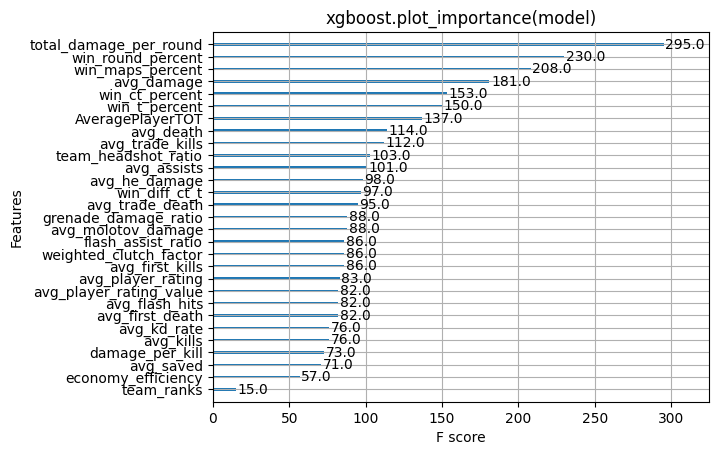

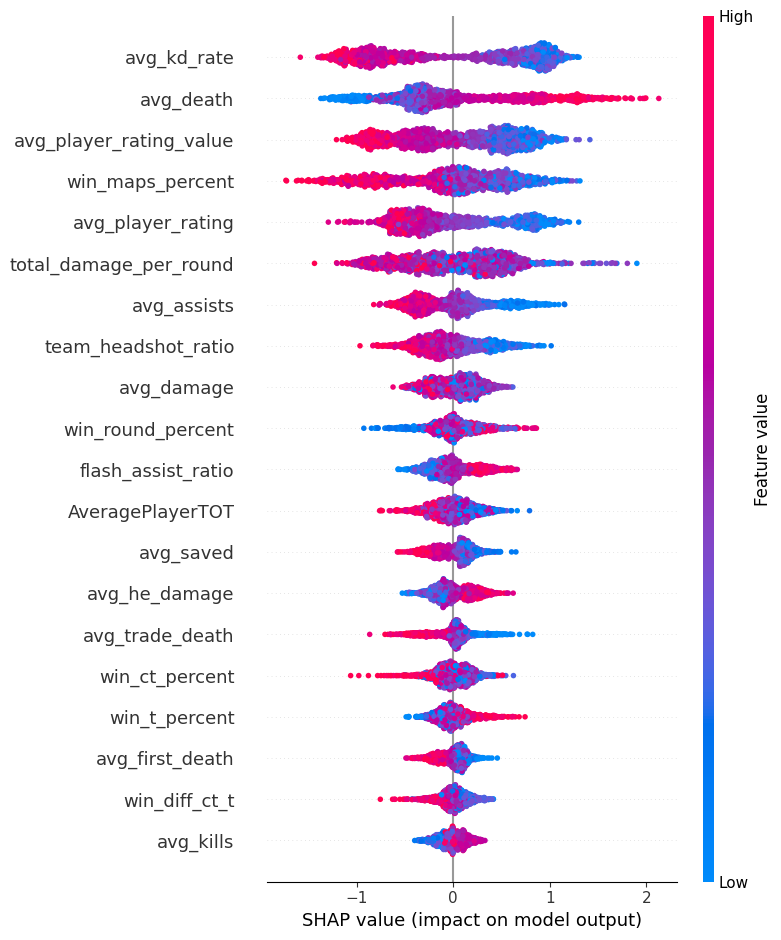

🎯 Stacked Model Accuracy: 0.8237
📊 Brier Score: 0.1210
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82       343
         1.0       0.83      0.82      0.82       349

    accuracy                           0.82       692
   macro avg       0.82      0.82      0.82       692
weighted avg       0.82      0.82      0.82       692

Prediction time xgb_calibrated!!!!!!!
    Match  Team 1 Win Probability (%)  Team 2 Win Probability (%)  \
0       1                    9.277448                   90.722557   
1       2                   78.083519                   21.916479   
2       3                    6.095924                   93.904076   
3       4                   19.353096                   80.646904   
4       5                   39.379040                   60.620964   
5       6                   44.527920                   55.472076   
6       7                   31.479242                   68.520760   
7       8                   

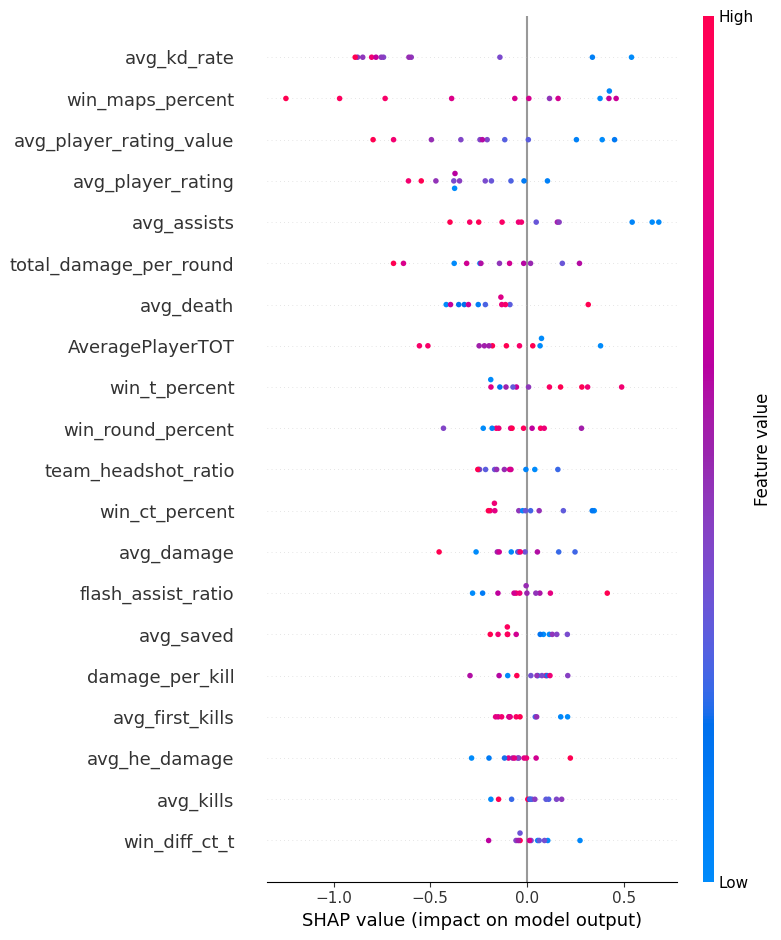

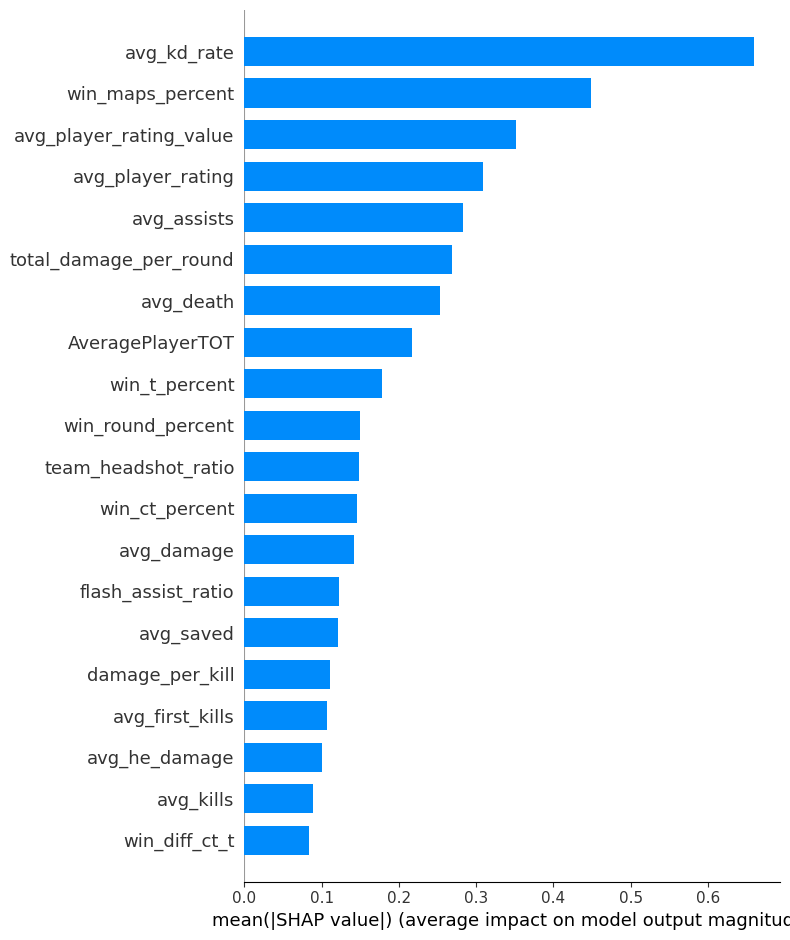

In [15]:
class base_preds:
    def reader(self):
        self.history_data = pd.read_csv("C:/Users/tyler/Documents/GitHub/eSports-Analytics/CS2/data_readonly.csv")
        self.upcoming_data = pd.read_csv("C:/Users/tyler/Documents/GitHub/eSports-Analytics/CS2/upcoming_readonly.csv")
    
    def temperature_scaling(self, probabilities, temperature=2.0):
        """
        Applies temperature scaling to soften probabilities.
        """
        probabilities = np.clip(probabilities, 1e-7, 1 - 1e-7)  # Avoid log(0) errors
        scaled_probs = probabilities ** (1.0 / temperature)  # Apply softmax-like scaling
        return scaled_probs / scaled_probs.sum(axis=1, keepdims=True)
        
    def train_xgboost(self):
        # Initialize the scaler
        self.scaler = MinMaxScaler()
        
        self.history_data['match_winner'] = 0
        self.history_data.dropna(inplace=True)

        # Feature Engineering
        self.history_data["win_diff_ct_t"] = self.history_data["win_ct_percent"] - self.history_data["win_t_percent"]
        self.history_data["total_damage_per_round"] = self.history_data["avg_damage"] / self.history_data["win_round_percent"]
        # df['feature_transformed'] = 1 / (df['feature'] + 1)  # Add 1 to avoid division by zero

        # Multiplicative Interactions instead of ratios for tree
        self.history_data['player_rating_x_value'] = (self.history_data["avg_player_rating"] * self.history_data["avg_player_rating_value"]) / 10000
        print(self.history_data['player_rating_x_value'].describe())
        
        self.history_data["damage_x_kill"] = (self.history_data["avg_damage"] * self.history_data["avg_kills"] ) / 1000
        print(self.history_data['damage_x_kill'].describe())
        
        self.history_data["flash_x_assist"] = self.history_data["avg_flash_hits"] * self.history_data["avg_assists"]
        self.history_data['win_percent_x_ct_and_t'] = (self.history_data["avg_he_damage"] + self.history_data["avg_molotov_damage"]) * self.history_data["avg_damage"]
        self.history_data["kill_x_trade_kill"] = (self.history_data["avg_kills"] * self.history_data["avg_trade_kills"]) / 1000
        self.history_data["first_death_x_trade_death"] = self.history_data["avg_first_death"] * self.history_data["avg_trade_death"]
        self.history_data["win_round_x_saved"] = self.history_data["win_round_percent"] * self.history_data["avg_saved"]
        self.history_data["rating_x_clutch_factor"] = self.history_data["avg_player_rating"] * self.history_data["weighted_clutch_factor"]
        self.history_data["clutch_x_saved"] = self.history_data["weighted_clutch_factor"] * self.history_data["avg_saved"]
        

        # print(self.history_data['player_rating_ratio'])
        # Feature Selection
        self.feature_columns = [
                    "avg_kills",
                    "avg_death",
                    "avg_assists",
                    "avg_damage",
                    "avg_kd_rate",
                    "avg_first_kills",
                    "avg_first_death",
                    "avg_trade_kills",
                    "avg_trade_death",
                    "avg_flash_hits",
                    "avg_he_damage",
                    "avg_molotov_damage",
                    "avg_saved",
                    "economy_efficiency",
                    "team_headshot_ratio",
                    "weighted_clutch_factor",
                    "grenade_damage_ratio",
                    "damage_per_kill",
                    "flash_assist_ratio",
                    "team_ranks",
                    "win_maps_percent",
                    "win_round_percent",
                    "win_ct_percent",
                    "win_t_percent",
                    "AveragePlayerTOT",
                    "win_diff_ct_t",
                    "total_damage_per_round",
                    "avg_player_rating",
                    "avg_player_rating_value"
                ]

        self.target_columns = ['match_winner']
        
        self.history_data = self.history_data.sample(frac=1).reset_index(drop=True)
        df_swapped = self.history_data.copy()
        swap_indices = self.history_data.sample(frac=0.5, random_state=42).index
        
        df_swapped.loc[swap_indices, self.feature_columns] *= -1
        df_swapped.loc[swap_indices, "match_winner"] = 1 - df_swapped.loc[swap_indices, "match_winner"]
        df_swapped.loc[swap_indices, ["match_winner_clan_score", "match_loser_clan_score"]] = \
            df_swapped.loc[swap_indices, ["match_loser_clan_score", "match_winner_clan_score"]].values
        self.history_data = df_swapped
        del df_swapped

        # Shuffle dataset to prevent patterns
        self.history_data = self.history_data.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Ensure all data is numeric
        self.history_data[self.feature_columns] = self.history_data[self.feature_columns].round(3).astype(float)
        self.history_data[self.target_columns] = self.history_data[self.target_columns].round(3).astype(float)

        # Replace inf values with a large finite number
        self.history_data.replace([np.inf, -np.inf], np.nan, inplace=True) 
        # self.history_data = self.history_data[self.feature_columns].apply(math.trunc)
        self.history_data.dropna(inplace=True)
        
        #adding Data Augmentation
        # self.history_data = pd.concat([self.history_data, self.mixup_data(self.history_data)])
        
        # Prepare training data
        self.X = self.history_data[self.feature_columns]
        self.X = self.X.round(3)
        self.Y = self.history_data[self.target_columns]


        print("Checking for infinite values:\n", np.isinf(self.X).sum())
        
        #Adding noise
        self.X = self.adversarial_noise(self.X, epsilon=0.05)
        
        # Split dataset (30% test size)
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.Y, test_size=0.3, random_state=42, stratify=self.Y)
        
        _, X_sample, _, Y_sample = train_test_split(self.X, self.Y, test_size=0.2, random_state=42, stratify=self.Y)
        # Perform train-test split on the smaller dataset
        self.temp_X_train, self.temp_X_test, self.temp_y_train, self.temp_y_test = train_test_split(
            X_sample, Y_sample, test_size=0.5, random_state=42, stratify=Y_sample
        )

        print(f"✅ Final Dataset Size: {self.history_data.shape}")
        print(f"✅ Temp Training Size: {len(self.temp_X_train)} - {len(self.temp_X_test)}")
        # X_train = self.scaler.fit_transform(X_train)
        # X_test = self.scaler.transform(X_test)
        self.X_train = pd.DataFrame(X_train, columns=self.feature_columns)
        self.X_test = pd.DataFrame(X_test, columns=self.feature_columns)
        
        self.Y_train = y_train
        self.Y_test = y_test

        best_params_xgb = {'booster': 'gbtree', 'colsample_bytree': 0.9353226711994892, 'eta': 0.18021493111971199, 'gamma': 0.30000000000000004, 'max_depth': 13, 'min_child_weight': 1, 'n_estimators': 7354, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 2.117031850169675, 'reg_lambda': 0.1196819561525524, 'seed': 42, 'subsample': 0.9300657250488755, 'tree_method': 'exact', 'verbosity': 0}
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # # #XGBoost Model best loss: 0.8145
        xgb_model = xgb.XGBClassifier(**best_params_xgb)
        cv_scores = cross_val_score(xgb_model, X_train, y_train.values.ravel(), cv=cv, scoring="accuracy", verbose=0)
        print(f"Cross-Validated XGBoost Model Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
        y_test = np.ravel(y_test)
        
        # Step 4: Train the Final XGBoost Model with Early Stopping
        xgb_model.fit(
            X_train, y_train.values.ravel(),
            eval_set=[(X_test, y_test)],
            verbose=0
        )
        
        xgb.plot_importance(xgb_model)
        pl.title("xgboost.plot_importance(model)")
        pl.show()
                
        explainer = shap.TreeExplainer(xgb_model)
        shap_values = explainer(self.X_train)
        shap.summary_plot(shap_values, self.X_train)

        # ✅ Get Predictions
        y_pred = xgb_model.predict(X_test)
        y_proba = xgb_model.predict_proba(X_test)[:, 1]
        
        self.xgb_model = xgb_model
        
        # ✅ Compute Accuracy & Brier Score
        accuracy = accuracy_score(y_test, y_pred)
        brier = brier_score_loss(y_test, y_proba)

        print(f"🎯 Stacked Model Accuracy: {accuracy:.4f}")
        print(f"📊 Brier Score: {brier:.4f}")  # Lower is better
        print(classification_report(y_test, y_pred)) 
    
    def add_random_noise(self, df, noise_fraction=0.40, noise_intensity=0.2):
        """ 
        Adds Gaussian noise to random rows and columns to introduce variability.
        
        Args:
        - df (DataFrame): Input dataset
        - noise_fraction (float): Fraction of rows to modify (e.g., 0.1 = 10% of rows)
        - noise_intensity (float): Noise intensity as a percentage of column std deviation
        
        Returns:
        - DataFrame with noise added
        """
        df_noisy = df.copy()
        
        # Get numeric columns only (skip categorical columns like 'match_map_name')
        num_cols = df_noisy.select_dtypes(include=['float64', 'int64']).columns.tolist()
        
        # Randomly select rows
        num_rows = int(noise_fraction * len(df_noisy))
        row_indices = np.random.choice(df_noisy.index, num_rows, replace=False)
        
        # Randomly select columns (subset of numeric columns)
        num_columns = int(0.7 * len(num_cols))  # Apply noise to 50% of numeric columns
        selected_cols = np.random.choice(num_cols, num_columns, replace=False)
        
        # Apply Gaussian noise to selected rows & columns
        for col in selected_cols:
            if col != "match_map_numeric":
                std_dev = df_noisy[col].std()  # Compute standard deviation
                noise = np.random.normal(loc=0, scale=noise_intensity * std_dev, size=num_rows)
                df_noisy.loc[row_indices, col] += noise  # Add noise only to selected rows

        return df_noisy

    #Data Augmentation (Mixes two different match samples to create a synthetic hybrid match.) 
    def mixup_data(self, df, alpha=5.0):
        """
        Apply MixUp augmentation to esports match data.
        alpha: Controls the mix intensity (higher = more aggressive).
        """
        df_mixed = df.copy()
        
        # Randomly shuffle dataset
        df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

        # Generate lambda values for interpolation
        lambda_vals = np.random.beta(alpha, alpha, df.shape[0]).reshape(-1, 1)  # Ensure correct shape

        # Apply MixUp to only selected feature columns
        df_mixed[self.feature_columns] = (lambda_vals * df[self.feature_columns].values) + \
                                        ((1 - lambda_vals) * df_shuffled[self.feature_columns].values)

        # Ensure the target variable (`match_winner`) is converted to NumPy array before multiplication
        df_mixed[self.target_columns] = (lambda_vals * df[self.target_columns].values) + \
                                        ((1 - lambda_vals) * df_shuffled[self.target_columns].values)

        # Drop NaN values from target variable
        df_mixed = df_mixed.dropna(subset=self.target_columns)

        # Convert target variable back to binary labels
        df_mixed[self.target_columns] = df_mixed[self.target_columns].round().astype(int)
        
        print(df_mixed)
        
        return df_mixed

    #applying adds small, targeted noise 
    def adversarial_noise(self, df, epsilon=0.01):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        noise = np.sign(np.random.randn(*df[numeric_cols].shape)) * epsilon  # Directional noise
        
        df_augmented = df.copy()
        df_augmented[numeric_cols] += noise  # Apply small perturbations
        
        return df_augmented

    def prediction(self):
        # Rename map column if necessary
        self.upcoming_data.rename(columns={'map': 'match_map_name'}, inplace=True)
        team_names = self.upcoming_data[['team1_slug', 'team2_slug']]
        
        # Feature Engineering
        # self.upcoming_data["kill_death_ratio"] = self.upcoming_data["avg_kills"] / (self.upcoming_data["avg_death"] + 1e-5)
        self.upcoming_data["win_diff_ct_t"] = self.upcoming_data["win_ct_percent"] - self.upcoming_data["win_t_percent"]
        self.upcoming_data["total_damage_per_round"] = self.upcoming_data["avg_damage"] / self.upcoming_data["win_round_percent"]
        self.upcoming_data["player_rating_ratio"] = self.upcoming_data["avg_player_rating"] / self.upcoming_data["avg_player_rating_value"]

                # Multiplicative Interactions instead of ratios for tree
        self.upcoming_data['player_rating_x_value'] = (self.upcoming_data["avg_player_rating"] * self.upcoming_data["avg_player_rating_value"]) / 10000
        self.upcoming_data['damage_x_kill'] = (self.history_data["avg_damage"] * self.history_data["avg_kills"] ) / 100
        self.upcoming_data["grenade_x_damage"] = (self.upcoming_data["avg_he_damage"] + self.upcoming_data["avg_molotov_damage"]) * self.upcoming_data["avg_damage"]
        self.upcoming_data["flash_x_assist"] = self.upcoming_data["avg_flash_hits"] * self.upcoming_data["avg_assists"]
        self.upcoming_data['win_percent_x_ct_and_t'] = (self.upcoming_data["avg_he_damage"] + self.upcoming_data["avg_molotov_damage"]) * self.upcoming_data["avg_damage"]
        self.upcoming_data["kill_x_trade_kill"] = (self.upcoming_data["avg_kills"] * self.upcoming_data["avg_trade_kills"]) /1000
        self.upcoming_data["first_death_x_trade_death"] = self.upcoming_data["avg_first_death"] * self.upcoming_data["avg_trade_death"]
        self.upcoming_data["win_round_x_saved"] = self.upcoming_data["win_round_percent"] * self.upcoming_data["avg_saved"]
        self.upcoming_data["rating_x_clutch_factor"] = self.upcoming_data["avg_player_rating"] * self.upcoming_data["weighted_clutch_factor"]
        self.upcoming_data["clutch_x_saved"] = self.upcoming_data["weighted_clutch_factor"] * self.upcoming_data["avg_saved"]
        
        # Drop unnecessary columns
        map_names = self.upcoming_data['match_map_name']
        self.upcoming_data.drop(columns=['match_map_name'], inplace=True)

        self.upcoming_data = self.upcoming_data[self.feature_columns]
        match_winner_predictions = []
        num_simulations = 100000
        
        random_X_pred = self.adversarial_noise(self.upcoming_data, epsilon=0.05)
        
        print("Prediction time xgb_calibrated!!!!!!!")
        y_proba = self.xgb_model.predict_proba(random_X_pred)[:, 1]
        
        prob_df = pd.DataFrame({
            "Match": range(1, len(y_proba) + 1),
            "Team 1 Win Probability (%)": y_proba * 100,
            "Team 2 Win Probability (%)": (1 - y_proba) * 100
        })
        prob_df = pd.concat([prob_df, team_names], axis=1)
        prob_df = pd.concat([prob_df, map_names], axis=1)
        print(prob_df)
        
        explainer = shap.TreeExplainer(self.xgb_model)
        shap_values = explainer.shap_values(random_X_pred)
        shap.summary_plot(shap_values, random_X_pred)
        shap.summary_plot(shap_values, random_X_pred, plot_type="bar")
        shap.force_plot(explainer.expected_value, shap_values[0,:], random_X_pred.iloc[0,:])

        
        
    def __init__(self):
        print("__init__")
        self.reader()
        self.train_xgboost()
        self.prediction()
        
        
base_preds()